In [1]:
using Yao, LinearAlgebra, Plots

### Training Target

In [2]:
function gaussian_pdf(x, μ::Real, σ::Real)
    pl = @. 1 / sqrt(2pi * σ^2) * exp(-(x - μ)^2 / (2 * σ^2))
    pl / sum(pl)
end
pg = gaussian_pdf(1:1<<6, 1<<5-0.5, 1<<4);

In [13]:
println(" x: ", 1<<6) # '0000001' -> '1000000' = 2^6
println("μ: ", 1<<5-0.5)
println("σ: ", 1<<4)

 x: 64
μ: 31.5
σ: 16


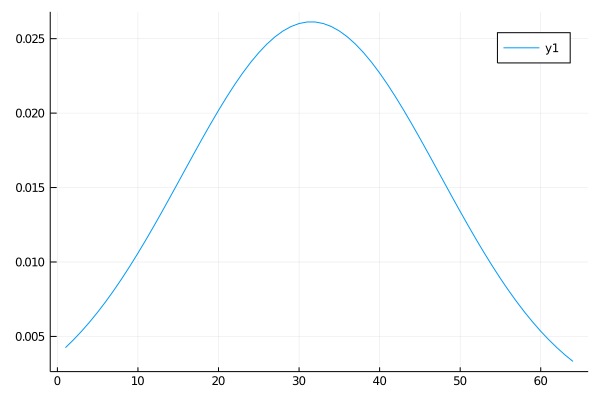

In [14]:
plot(pg)

### Create the Circuit

In [15]:
chain(Rz(0.0), Rx(0.0), Rz(0.0))

nqubits: 1
chain
├─ rot(Z, 0.0)
├─ rot(X, 0.0)
└─ rot(Z, 0.0)

In [16]:
layer(nbit::Int, x::Symbol) = layer(nbit, Val(x))
layer(nbit::Int, ::Val{:first}) = chain(nbit, put(i=>chain(Rx(0), Rz(0))) for i = 1:nbit);

In [17]:
layer(nbit::Int, ::Val{:last}) = chain(nbit, put(i=>chain(Rz(0), Rx(0))) for i = 1:nbit)
layer(nbit::Int, ::Val{:mid}) = chain(nbit, put(i=>chain(Rz(0), Rx(0), Rz(0))) for i = 1:nbit);

In [18]:
entangler(pairs) = chain(control(ctrl, target=>X) for (ctrl, target) in pairs);

In [19]:
function build_circuit(n, nlayers, pairs)
    circuit = chain(n)
    push!(circuit, layer(n, :first))
    for i in 2:nlayers
        push!(circuit, cache(entangler(pairs)))
        push!(circuit, layer(n, :mid))
    end
    push!(circuit, cache(entangler(pairs)))
    push!(circuit, layer(n, :last))
    return circuit
end

build_circuit (generic function with 1 method)

We use the method cache here to tag the entangler block that it should be cached after its first run, because it is actually a constant oracle. Let's see what will be constructed

In [45]:
build_circuit(4, 1, [1=>2, 2=>3, 3=>4])

nqubits: 4
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X, 0.0)
│  │     └─ rot(Z, 0.0)
│  ├─ put on (2)
│  │  └─ chain
│  │     ├─ rot(X, 0.0)
│  │     └─ rot(Z, 0.0)
│  ├─ put on (3)
│  │  └─ chain
│  │     ├─ rot(X, 0.0)
│  │     └─ rot(Z, 0.0)
│  └─ put on (4)
│     └─ chain
│        ├─ rot(X, 0.0)
│        └─ rot(Z, 0.0)
├─ [cached] chain
│     ├─ control(1)
│     │  └─ (2,) X
│     ├─ control(2)
│     │  └─ (3,) X
│     └─ control(3)
│        └─ (4,) X
└─ chain
   ├─ put on (1)
   │  └─ chain
   │     ├─ rot(Z, 0.0)
   │     └─ rot(X, 0.0)
   ├─ put on (2)
   │  └─ chain
   │     ├─ rot(Z, 0.0)
   │     └─ rot(X, 0.0)
   ├─ put on (3)
   │  └─ chain
   │     ├─ rot(Z, 0.0)
   │     └─ rot(X, 0.0)
   └─ put on (4)
      └─ chain
         ├─ rot(Z, 0.0)
         └─ rot(X, 0.0)


### MMD Loss & Gradients

In [21]:
struct RBFKernel
    σ::Float64
    m::Matrix{Float64}
end

function RBFKernel(σ::Float64, space)
    dx2 = (space .- space').^2
    return RBFKernel(σ, exp.(-1/2σ * dx2))
end

kexpect(κ::RBFKernel, x, y) = x' * κ.m * y

kexpect (generic function with 1 method)

In [33]:
get_prob(qcbm) = probs(zero_state(nqubits(qcbm)) |> qcbm)

function loss(κ, c, target)
    p = get_prob(c) - target
    return kexpect(κ, p, p)
end

loss (generic function with 1 method)

### Gradient

In [35]:
# Gradient of MMD loss

function gradient(qcbm, κ, ptrain)
    n = nqubits(qcbm)
    prob = get_prob(qcbm)
    grad = zeros(Float64, nparameters(qcbm))

    count = 1
    for k in 1:2:length(qcbm), each_line in qcbm[k], gate in content(each_line)
        dispatch!(+, gate, π/2)
        prob_pos = probs(zero_state(n) |> qcbm)

        dispatch!(-, gate, π)
        prob_neg = probs(zero_state(n) |> qcbm)

        dispatch!(+, gate, π/2) # set back

        grad_pos = kexpect(κ, prob, prob_pos) - kexpect(κ, prob, prob_neg)
        grad_neg = kexpect(κ, ptrain, prob_pos) - kexpect(κ, ptrain, prob_neg)
        grad[count] = grad_pos - grad_neg
        count += 1
    end
    return grad
end

gradient (generic function with 1 method)

### Training

In [53]:
using Flux#.Optimise
qcbm = build_circuit(6, 10, [1=>2, 3=>4, 5=>6, 2=>3, 4=>5, 6=>1]) # 6qubits, 10layers
dispatch!(qcbm, :random) # initialize the parameters

κ = RBFKernel(0.25, 0:2^6-1)
pg = gaussian_pdf(1:1<<6, 1<<5-0.5, 1<<4);
opt = ADAM()

function train(qcbm, κ, opt, target)
    history = Float64[]
    for _ in 1:100
        push!(history, loss(κ, qcbm, target)) # first loss
        ps = parameters(qcbm) # temporaly params
        Flux.Optimise.update!(opt, ps, gradient(qcbm, κ, target)) # update params
        popdispatch!(qcbm, ps) # apply params
    end
    return history
end

history = train(qcbm, κ, opt, pg)
trained_pg = probs(zero_state(nqubits(qcbm)) |> qcbm)

64-element Array{Float64,1}:
 0.01060826815617938
 0.010057191531288596
 0.0075143990781667246
 0.015117567544464522
 0.009740640025847552
 0.009273595171037489
 0.012034845532708033
 0.013234188492832363
 0.012840261987020736
 0.00368240920623575
 0.012817726832787571
 0.013617878661462607
 0.007376884901485797
 ⋮
 0.014951375944954222
 0.011468064446544782
 0.008453126814320687
 0.011069608092805345
 0.011867458924947696
 0.00850504724904761
 0.010336403441851778
 0.012943935275279983
 3.5905911934497564e-5
 0.009151701458036489
 0.003941247127145497
 0.0023804508271697234

In [51]:
# "Symbol type" http://bicycle1885.hatenablog.com/entry/2015/08/15/143620
typeof(:random)

Symbol

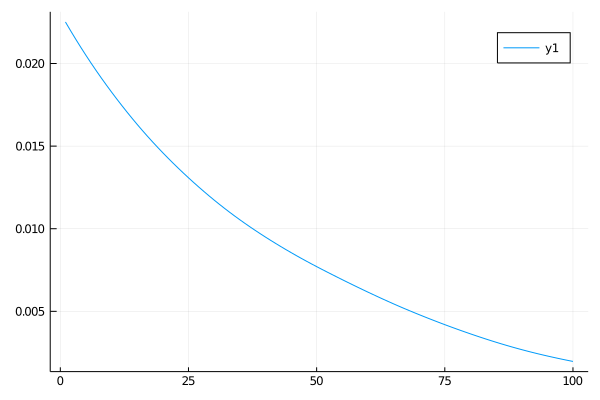

In [54]:
title!("training history")
xlabel!("steps"); ylabel!("loss")
plot(history)

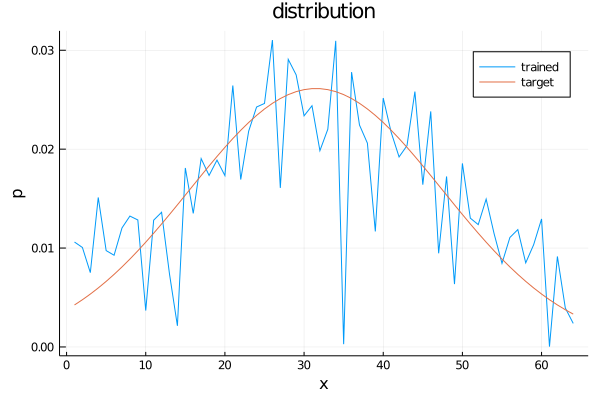

In [55]:
fig2 = plot(1:1<<6, trained_pg; label="trained")
plot!(fig2, 1:1<<6, pg; label="target")
title!("distribution")
xlabel!("x"); ylabel!("p")